## Importing the libraries

In [1]:
from functions import *

# Model Application on BankNote DataSet With Bruteforce Feature Selection

################################# Starting Preprocessing #################################
Preprocessing Done
################################# Visualizing Data #################################


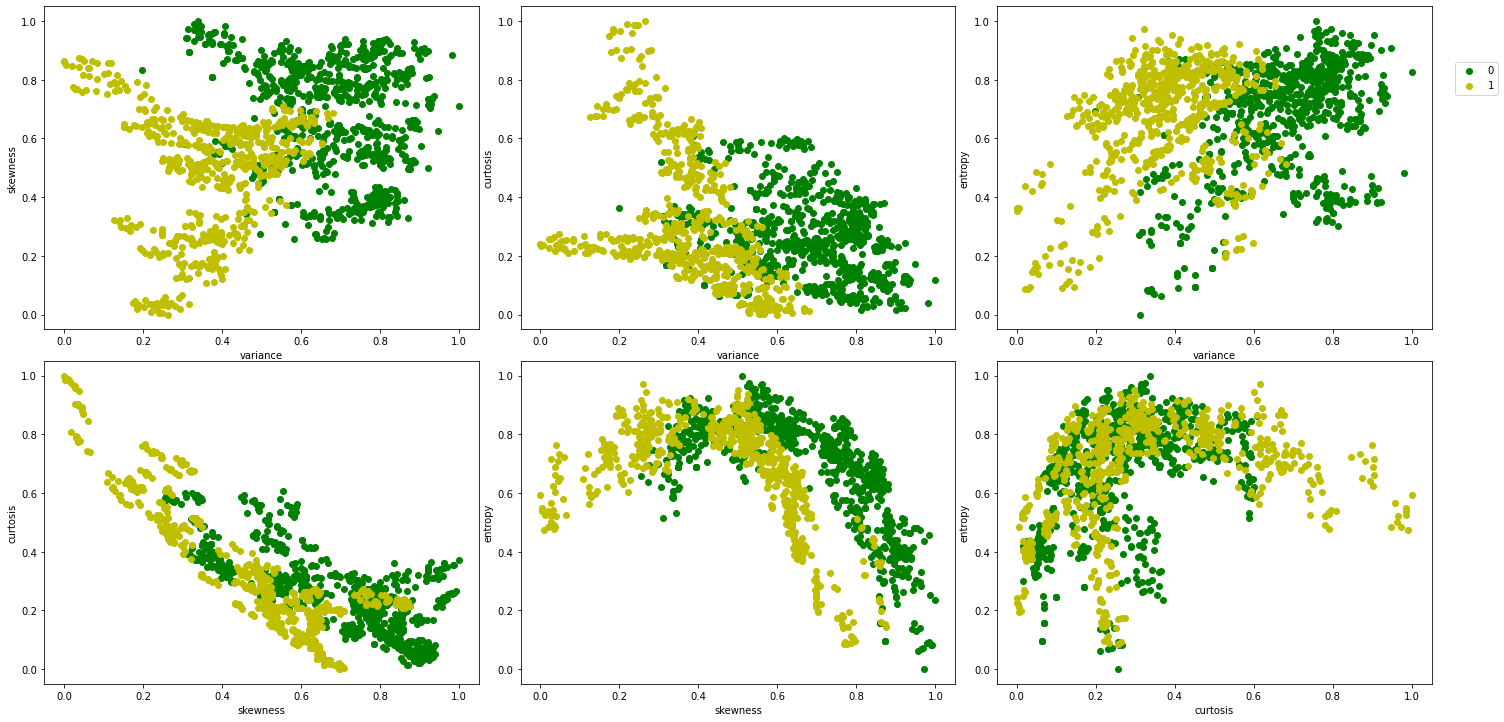

################################# Starting Bruteforce Feature Selection #################################


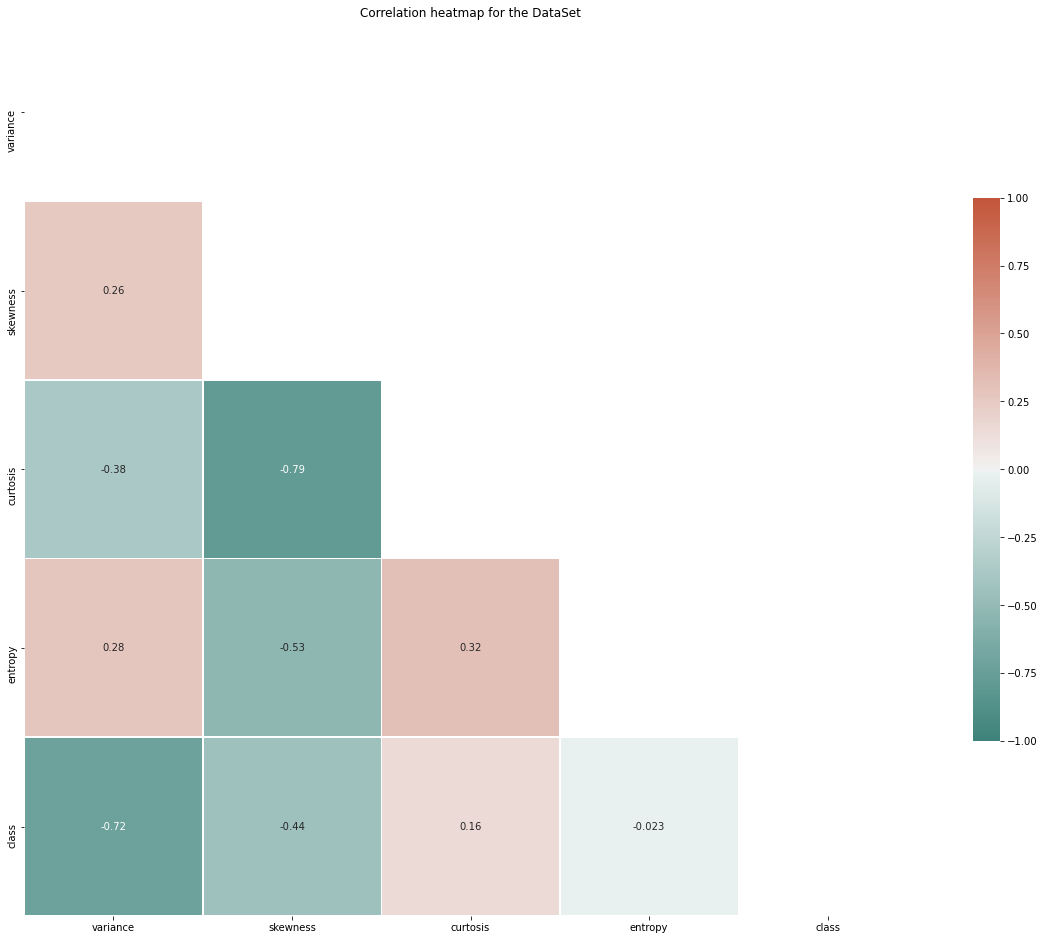

################################# Best Model Chosen by GridSearch #################################
{'classifier': KNeighborsClassifier(metric='manhattan', n_neighbors=11, weights='distance'), 'classifier__metric': 'manhattan', 'classifier__n_neighbors': 11, 'classifier__weights': 'distance'}
The accuracy of the chosen model is  0.97
The precision of the chosen model is  0.94
The recall of the chosen model is  0.99
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       259
           1       0.94      0.99      0.96       194

    accuracy                           0.97       453
   macro avg       0.96      0.97      0.97       453
weighted avg       0.97      0.97      0.97       453





In [2]:
apply_model("BankNoteAuthentication.csv", 'f1', pca=False)

# Model Application on BankNote DataSet With PCA

################################# Starting Preprocessing #################################
Preprocessing Done
################################# Visualizing Data #################################


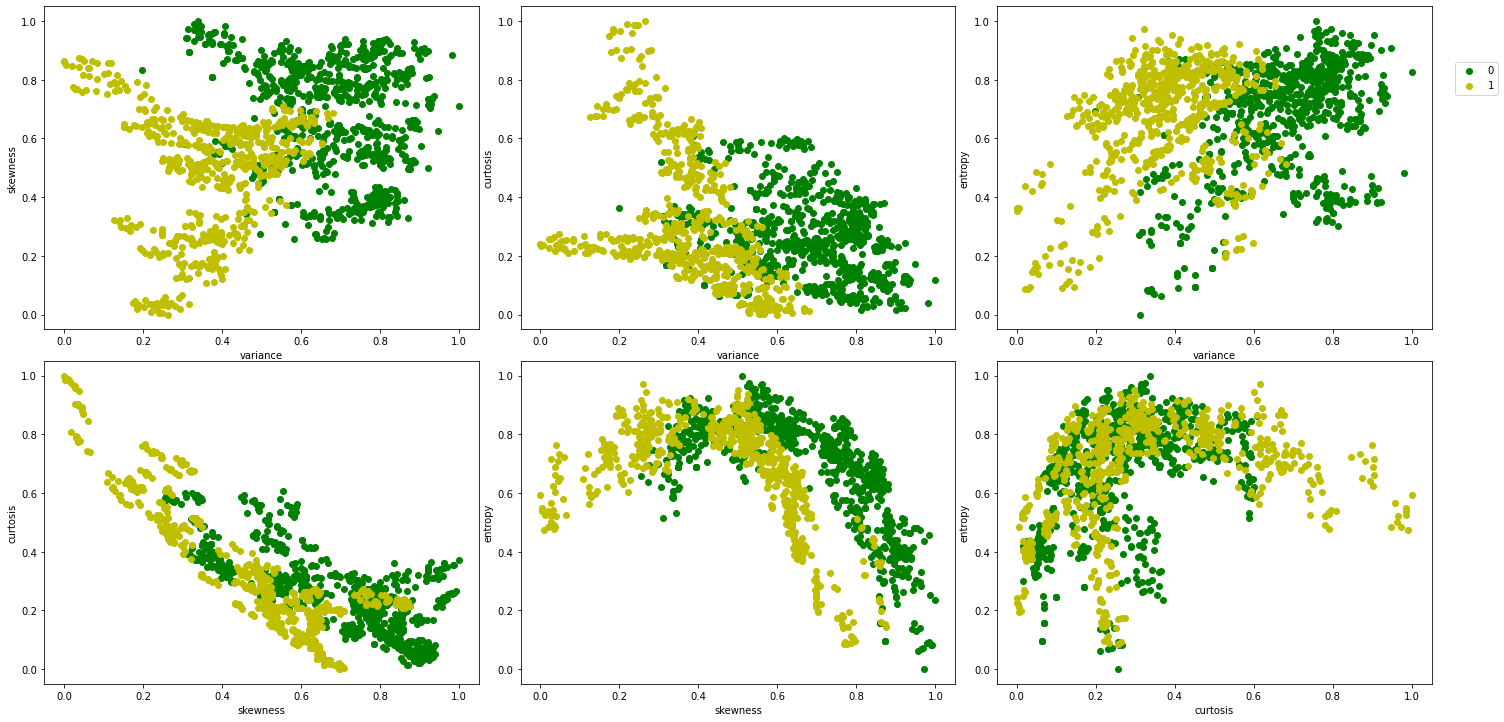

################################# Best Model Chosen by GridSearch #################################
{'classifier': KNeighborsClassifier(metric='euclidean', weights='distance'), 'classifier__metric': 'euclidean', 'classifier__n_neighbors': 5, 'classifier__weights': 'distance'}
The accuracy of the chosen model is  0.98
The precision of the chosen model is  0.97
The recall of the chosen model is  0.98
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       259
           1       0.97      0.98      0.98       194

    accuracy                           0.98       453
   macro avg       0.98      0.98      0.98       453
weighted avg       0.98      0.98      0.98       453





In [3]:
apply_model("BankNoteAuthentication.csv", 'f1', pca=True)

# Model Application on Kidney Disease Dataset With Bruteforce Feature Selection

################################# Starting Preprocessing #################################
Preprocessing Done
################################# Visualizing Data #################################


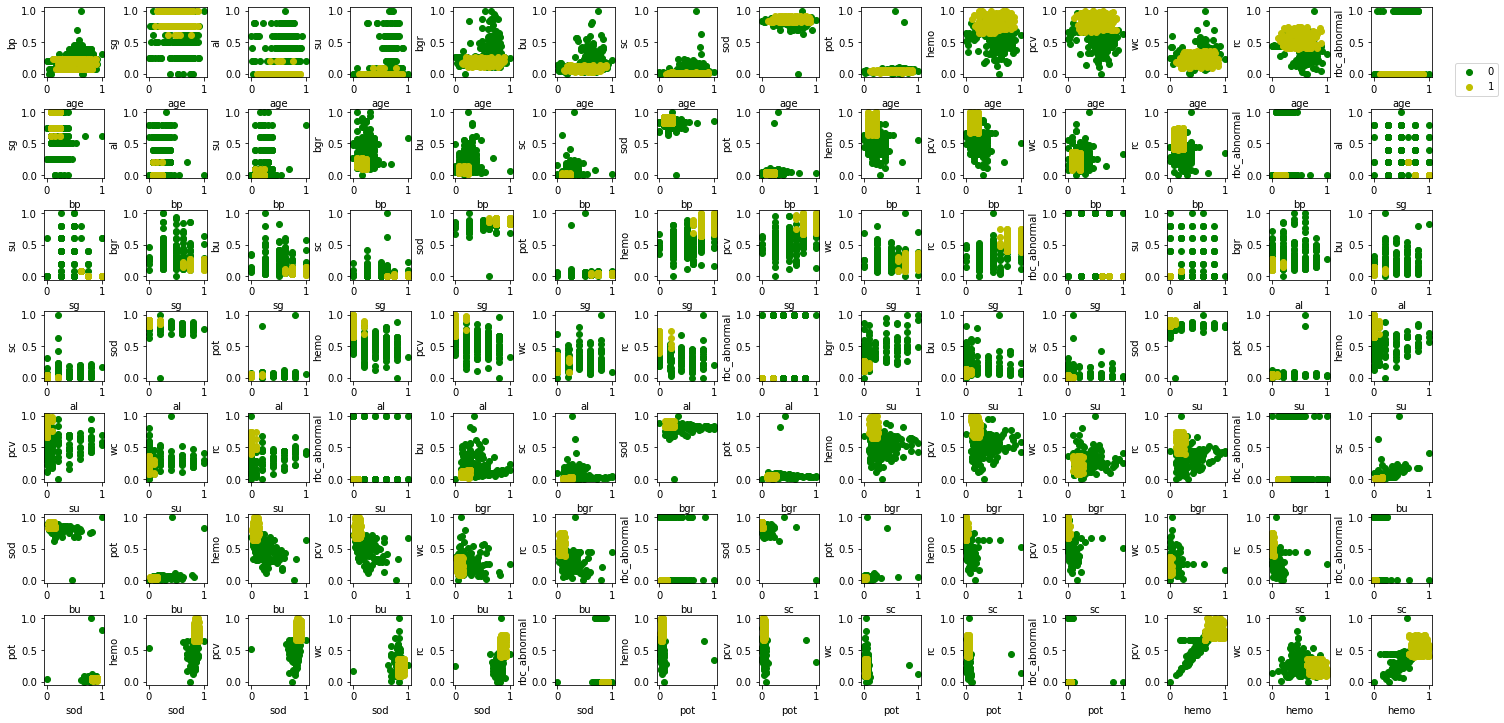

################################# Starting Bruteforce Feature Selection #################################


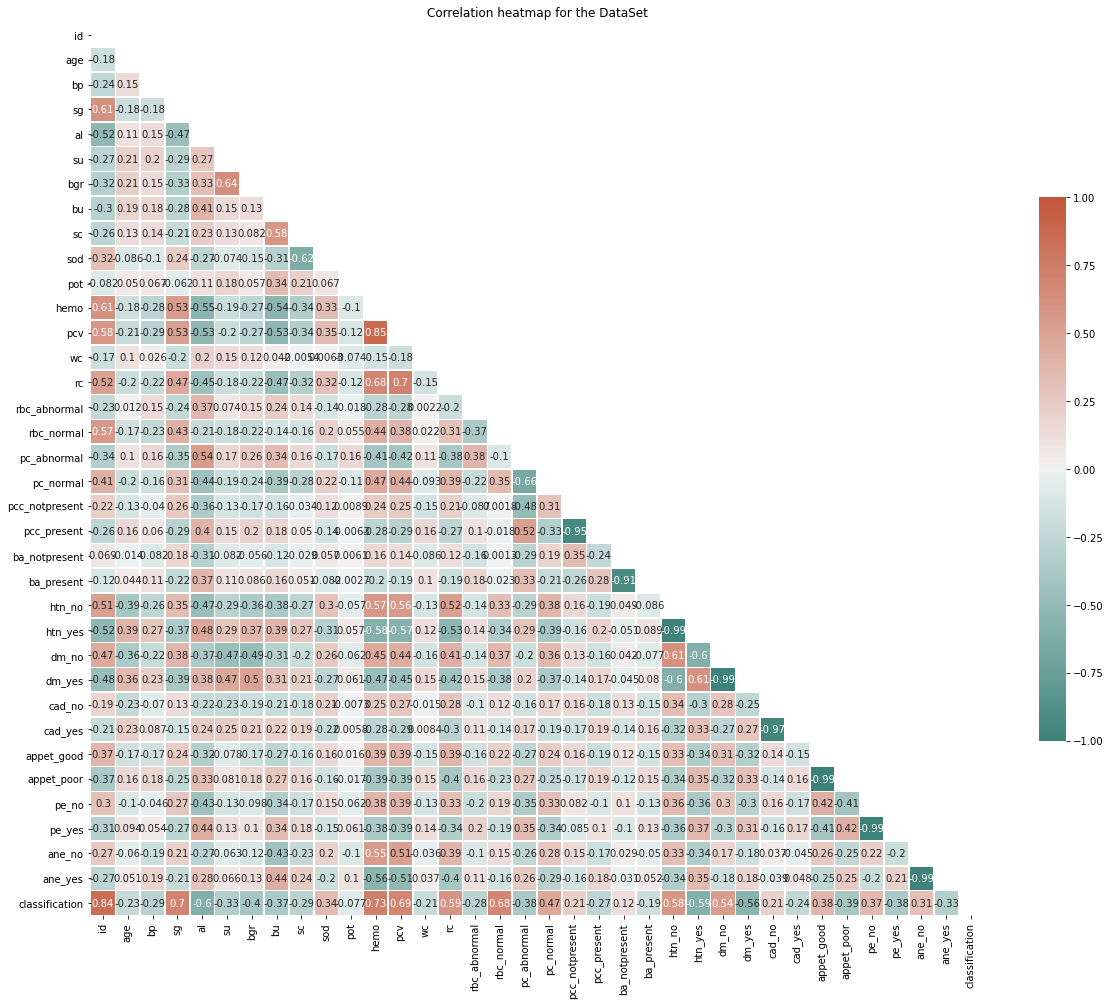

################################# Best Model Chosen by GridSearch #################################
{'classifier': DecisionTreeClassifier(max_depth=2), 'classifier__criterion': 'gini', 'classifier__max_depth': 2}
The accuracy of the chosen model is  0.99
The precision of the chosen model is  1.00
The recall of the chosen model is  0.98
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        76
           1       1.00      0.98      0.99        56

    accuracy                           0.99       132
   macro avg       0.99      0.99      0.99       132
weighted avg       0.99      0.99      0.99       132





In [4]:
apply_model("kidney_disease.csv", 'recall', pca=False)

# Model Application on Kidney Disease Dataset With PCA

################################# Starting Preprocessing #################################
Preprocessing Done
################################# Visualizing Data #################################


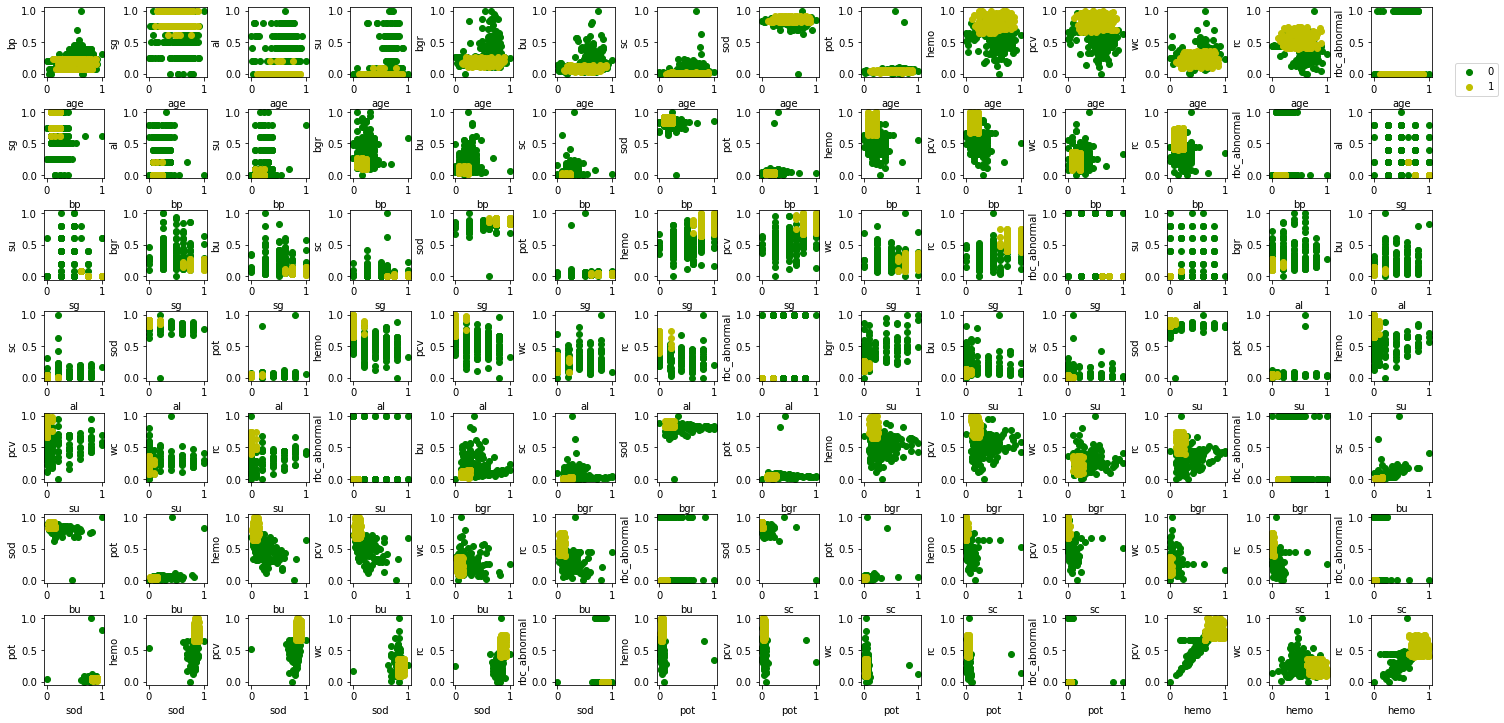

################################# Best Model Chosen by GridSearch #################################
{'classifier': SVC(C=1, gamma=1, kernel='poly'), 'classifier__C': 1, 'classifier__gamma': 1, 'classifier__kernel': 'poly'}
The accuracy of the chosen model is  0.99
The precision of the chosen model is  0.98
The recall of the chosen model is  1.00
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        76
           1       0.98      1.00      0.99        56

    accuracy                           0.99       132
   macro avg       0.99      0.99      0.99       132
weighted avg       0.99      0.99      0.99       132





In [5]:
apply_model("kidney_disease.csv", 'recall', pca=True)